# WOfS Collection Upgrade Testing

Preliminaries:

In [1]:
import datacube
import matplotlib.pyplot as plt, cartopy.crs, numpy as np, pandas, datetime

In [2]:
dc = datacube.Datacube()

## Locating the sample data

First step is confirming access to new and old datasets.

In [3]:
[n for n in dc.list_products().name.to_list() if 'wo' in n.lower()]

['ga_ls_wofs_3',
 'sentinel2_wofs_nrt',
 'wofs_albers',
 'wofs_annual_summary',
 'wofs_apr_oct_summary',
 'wofs_filtered_summary',
 'wofs_nov_mar_summary',
 'wofs_summary']

In [4]:
[dc.index.datasets.count(product=i) for i in ['ga_ls_wofs_3', 'wofs_summary', 'wofs_albers']]

[18913, 1244, 3069704]

In [5]:
records = dc.find_datasets(product='ga_ls_wofs_3')
len(records)

18913

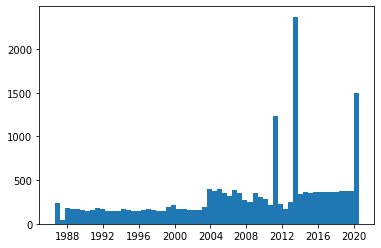

In [6]:
plt.hist([i.key_time for i in records], bins=60); None

In [7]:
set(i.crs for i in records)

{CRS('epsg:32649'),
 CRS('epsg:32650'),
 CRS('epsg:32651'),
 CRS('epsg:32652'),
 CRS('epsg:32653'),
 CRS('epsg:32654'),
 CRS('epsg:32655'),
 CRS('epsg:32656')}

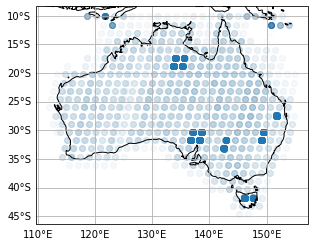

In [8]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.scatter(*zip(*[(i.extent.centroid.to_crs('epsg:4326').points)[0] for i in records]), alpha=0.02)
ax.coastlines()
g = ax.gridlines(draw_labels=True); g.top_labels = g.right_labels = False
None

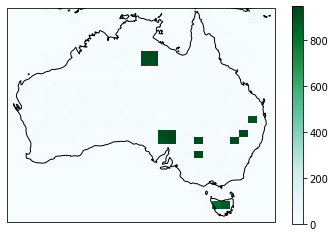

In [9]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
plt.colorbar(ax.hist2d(*zip(*[(i.extent.centroid.to_crs('epsg:4326').points)[0] for i in records]), 
                       bins=30, cmap='BuGn')[-1])
None

Evidently we have access both to the previous existing WOfS product, and to some samples of the new collection "3" WOFLs.

The new samples appear to have shallow comprehensive coverage, and probably full temporal coverage in a handful of spatial locations (including path/row neighbours). 

## Matching old and new datasets for comparison

Most likely there is a simple time offset. For simplicity, to avoid querying the full archive of old datasets, the analysis is restricted spatially.

In [10]:
lat, lon = -32, 138
lat, lon = -41.8, 147 # Tasmania
lat, lon = -41.8, 146 # Tasmania, more mountainous

In [11]:
new = dc.find_datasets(product='ga_ls_wofs_3', lat=lat, lon=lon)
old = dc.find_datasets(product='wofs_albers', lat=lat, lon=lon)
len(old), len(new)

(713, 819)

In [12]:
t0 = [i.key_time for i in old]
t1 = [i.key_time for i in new]

-0.4877510070800781

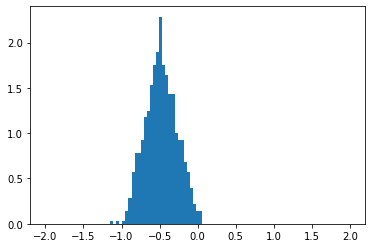

In [13]:
common_dates = set(i.date() for i in t0) & set(i.date() for i in t1)
T0 = np.asarray(sorted(i.timestamp() for i in t0 if i.date() in common_dates))
T1 = np.asarray(sorted(i.timestamp() for i in t1 if i.date() in common_dates))
plt.hist(T0 - T1, bins=np.linspace(-2, 2, 100), density=True)
np.median(T0 - T1) # mean is a poor estimator due to outlying mismatches

This shows that the temporal index of the new product leads that of the old product by a half second, give or take a second. This is as though the old product had truncated the milliseconds. 

It is not too difficult to match most pairs, even without using a tolerance time window. (Those that are missed might also be more likely to contain different extents between versions.)

516

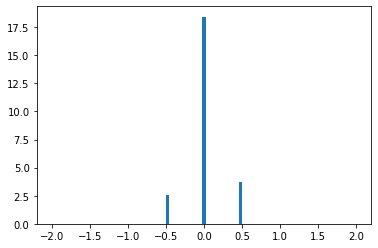

In [14]:
rounding = 0.5
offset = 0.5 # why was this needed?
oldtime = lambda t: datetime.datetime.fromtimestamp(round((t.timestamp() - offset) / rounding) * rounding)
t2 = [oldtime(i) for i in t1]

T2 = np.asarray(sorted(i.timestamp() for i in t2 if i.date() in common_dates))
plt.hist(T0 - T2, bins=np.linspace(-2, 2, 100), density=True)

len(set(t0) & set(t2))

In [15]:
Old = pandas.Series(old)
Old.index = Old.apply(lambda i: i.key_time)

New = pandas.Series(new)
New.index = New.apply(lambda i: oldtime(i.key_time)) # use compatible temporal indexes

table = pandas.DataFrame(dict(old=Old, new=New)).dropna() # combine and only retain index matches
len(table)

516

In [16]:
e = 0.1
spatial = dict(lat=(lat-e, lat+e), lon=(lon-e,lon+e))
x0 = dc.load(datasets=table.old.to_list(), output_crs='epsg:3577', resolution=(25,-25), **spatial)
x1 = dc.load(datasets=table.new.to_list(), output_crs='epsg:3577', resolution=(25,-25), **spatial)

## Compare old and new datasets

Now that comparable example datasets are available (in memory), wish to analyse how (if at all) they differ.

It is immediately obvious that they do not have the same data type and value range.

In [17]:
x0.water.shape, x1.water.shape, x0.water.dtype, x1.water.dtype, x0.water.size, x1.water.size

((516, 938, 773),
 (516, 938, 773),
 dtype('int16'),
 dtype('uint8'),
 374138184,
 374138184)

In [18]:
(x0.water.data == x1.water.data).mean()

0.39582711771541607

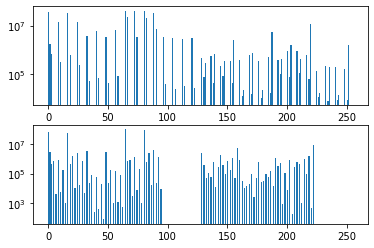

In [19]:
plt.subplot(2, 1, 1).hist(x0.water.data.ravel(), bins=range(256)); plt.yscale('log', nonposy='clip')
plt.subplot(2, 1, 2).hist(x1.water.data.ravel(), bins=range(256)); plt.yscale('log', nonposy='clip')
None

Some potential value differences are:

- Originally the third (least significant) bit was for ocean. This has been repurposed for grazing insolation, which was previously combined into the fourth bit together with terrain shadow.

- The new pixel quality algorithm makes some categories mutually exclusive (viz. python-fmask gives cloud precedence over cloud-shadow).

- For pixels masked as no-data, the other fields are meaningless.

In [20]:
z0 = x0.water.data.copy()
z1 = x1.water.data.copy()

z0[(z0 & 1).astype(np.bool)] = 1 # single flavour of nodata

z0[(z0 & 2).astype(np.bool)] = 2 # Similarly, not concerned here with
z1[(z1 & 2).astype(np.bool)] = 2 # treatment of noncontiguous data.

z0 &= ~np.uint8(4) # disregard ocean

z1[(z1 & 4).astype(np.bool)] |= 8 # bundle insolation with terrain shadow
z1 &= ~np.uint8(4)

z0[(z0 & 64).astype(np.bool)] &= ~np.uint8(32) # precedence of cloud over cloud-shadow

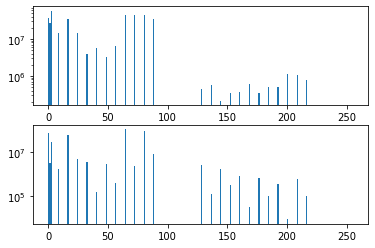

In [21]:
plt.subplot(2, 1, 1).hist(z0.ravel(), bins=range(256)); plt.yscale('log', nonposy='clip')
plt.subplot(2, 1, 2).hist(z1.ravel(), bins=range(256)); plt.yscale('log', nonposy='clip')

In [22]:
u0, c0 = np.unique(z0, return_counts=True)
u1, c1 = np.unique(z1, return_counts=True)

set(u0) ^ set(u1) # non-overlap

set()

# How does the data look, spatially?

Sanity check: clear observation count.

The new version deems more of the observations to be clear.

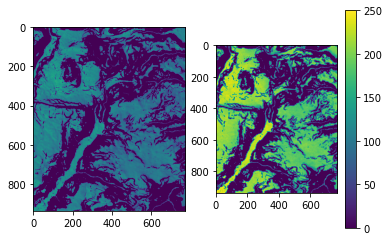

In [23]:
m0 = plt.subplot(1, 2, 1).imshow(((z0 == 0) | (z0 == 128)).sum(axis=0), vmax=250)
m1 = plt.subplot(1, 2, 2).imshow(((z1 == 0) | (z1 == 128)).sum(axis=0), vmax=250)
plt.colorbar(m1); None

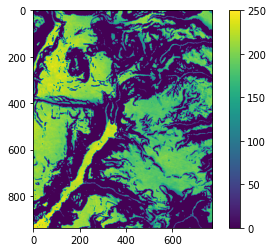

In [24]:
plt.imshow(((z1 == 0) | (z1 == 128)).sum(axis=0), vmax=250)
plt.colorbar(); None

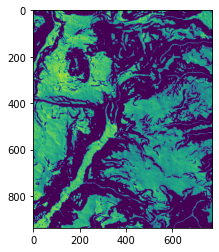

In [25]:
plt.imshow((x0.water.data & ~np.uint8(128) == 0).sum(axis=0))

In [26]:
z0.shape, z1.shape

((516, 938, 773), (516, 938, 773))

## How do the actual values differ?

In [27]:
(z0 == z1).mean()

0.42457662380699424

In [28]:
for bit in range(8):
    x = 2**bit
    print(x, ((z0 & x) == (z1 & x)).mean())

1 0.9269046112652324
2 0.7863863101447031
4 1.0
8 0.7059187628921618
16 0.8998164966770673
32 0.9422213798952955
64 0.7977445814512213
128 0.9893625238743341


Most pixels differ in some manner.

In [29]:
good = ~ ((z0 & 3) | (z1 & 3)).astype(np.bool)
for bit in range(8):
    x = 2**bit
    print(x, ((z0[good] & x) == (z1[good] & x)).mean(), 
          (z0[good] & x).astype(np.bool).mean(), (z1[good] & x).astype(np.bool).mean())
(z0[good] == z1[good]).mean()

1 1.0 0.0 0.0
2 1.0 0.0 0.0
4 1.0 0.0 0.0
8 0.6308438676988295 0.42058683603609887 0.054461885559749255
16 0.9723622788798509 0.47761479178610317 0.47310080381063974
32 0.9265443291420906 0.07282908748930186 0.029119045591551932
64 0.9266463389318097 0.5784488794628583 0.5092071217531761
128 0.9870329206623617 0.023600607782041618 0.025596770573666654


0.5396974580029237

Among the pixels with completely valid data, half still differ.

The differences are usually in terrain insolation (40% -> 5%), and to a lesser extent in cloud (58% -> 51%) and cloud shadow (7% -> 3%).

The water classifier, and the slope, are highly consistent.

In [30]:
vgood = good & ~((z0 & 8) | (z1 & 8)).astype(np.bool)
good.mean(), vgood.mean()

(0.7684637208801975, 0.4440933192747843)

In [31]:
g0 = z0[good] & ~np.uint8(8) # ignore terrain bit
g1 = z1[good] & ~np.uint8(8)
for bit in range(8):
    x = 2**bit
    print(x, ((g0 & x) == (g1 & x)).mean(), 
          (g0 & x).astype(np.bool).mean(), (g1 & x).astype(np.bool).mean())
(g0 == g1).mean()

1 1.0 0.0 0.0
2 1.0 0.0 0.0
4 1.0 0.0 0.0
8 1.0 0.0 0.0
16 0.9723622788798509 0.47761479178610317 0.47310080381063974
32 0.9265443291420906 0.07282908748930186 0.029119045591551932
64 0.9266463389318097 0.5784488794628583 0.5092071217531761
128 0.9870329206623617 0.023600607782041618 0.025596770573666654


0.8355988991484974

In [32]:
(7.28 - 0.291) / 7.28, (57.84 - 50.92) / 57.84

(0.9600274725274724, 0.11964038727524207)

Even ignoring the terrain mask, only ~80% of pixels are identical. The water mask is very consistent, the slope mask is similar, but the cloud and especially cloud shadow are significantly reduced.

This might affect the area of unmasked water.

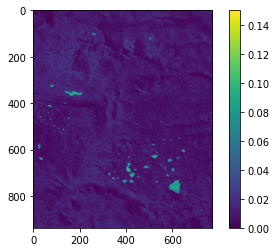

In [33]:
plt.imshow(((z0 & 128) != (z1 & 128)).mean(axis=0), vmax=0.15)
plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


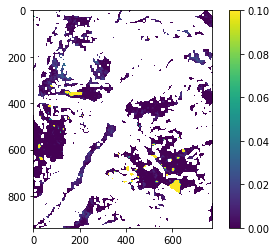

In [34]:
w0 = (z0 == 128).sum(axis=0)
w1 = (z1 == 128).sum(axis=0)
d0 = (z0 == 0).sum(axis=0)
d1 = (z1 == 0).sum(axis=0)
plt.imshow(w0 / (w0 + d0), vmax=0.1); plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


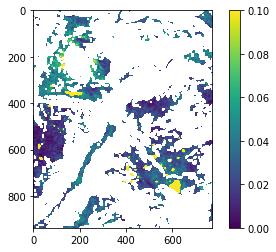

In [35]:
plt.imshow(w1 / (w1 + d1), vmax=0.1); plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


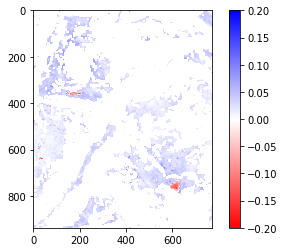

In [36]:
plt.imshow(w1 / (w1 + d1) - w0 / (w0 + d0), vmax=0.2, vmin=-0.2, cmap='bwr_r'); plt.colorbar(); None

## Change attributable to terrain illumination
If the old data used the new insolation threshold? This would not capture the majority of variation between the old and new summaries (although it is a significant portion, probably more so than other factors following).

/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


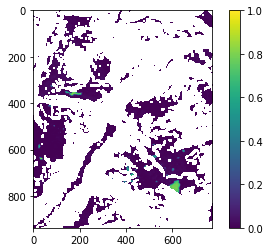

In [37]:
w_ = (((z0 & ~np.uint8(8)) | (z1 & np.uint8(8))) == 128).sum(axis=0)
d_ = (((z0 & ~np.uint8(8)) | (z1 & np.uint8(8))) == 0).sum(axis=0)
plt.imshow(w_ / (w_ + d_)); plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


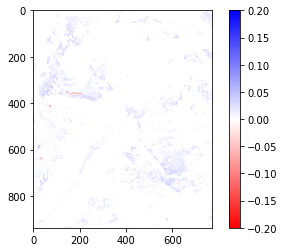

In [38]:
plt.imshow(w_ / (w_ + d_) - w0 / (w0 + d0), vmax=0.2, vmin=-0.2, cmap='bwr_r'); plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


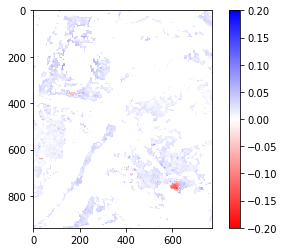

In [39]:
plt.imshow(w1 / (w1 + d1) - w_ / (w_ + d_), vmax=0.2, vmin=-0.2, cmap='bwr_r'); plt.colorbar(); None

## Change attributable to the water classifier (or EO measurement bands)
The input product is different (even if only the projection is different, the individual pixel values send to the decision tree are not the same). Hence the water classifications are different. Focusing on change to this output, while retaining the full set of original masks.

The differences do have a spatial structure (increasing wet frequency in some areas, reducing it in others). But these differences are small; the change in masks is much more profound (particularly concerning background noise extent).

/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


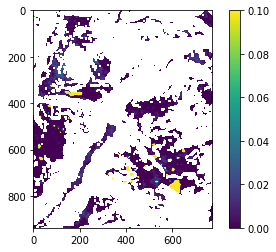

In [40]:
w_ = (((z0 & ~np.uint8(128)) | (z1 & np.uint8(128))) == 128).sum(axis=0)
d_ = (((z0 & ~np.uint8(128)) | (z1 & np.uint8(128))) == 0).sum(axis=0)
plt.imshow(w_ / (w_ + d_), vmax=0.1); plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


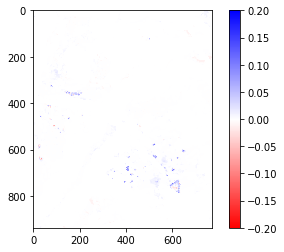

In [41]:
plt.imshow(w_ / (w_ + d_) - w0 / (w0 + d0), vmax=0.2, vmin=-0.2, cmap='bwr_r'); plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


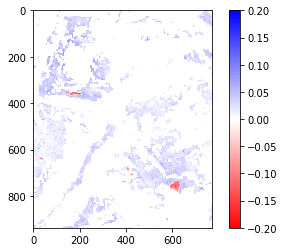

In [42]:
plt.imshow(w1 / (w1 + d1) - w_ / (w_ + d_), vmax=0.2, vmin=-0.2, cmap='bwr_r'); plt.colorbar(); None

## Change attributable to new *cloud* mask

/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


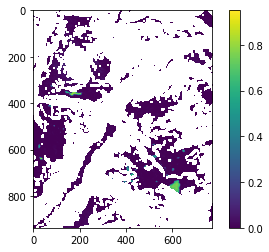

In [43]:
w_ = (((z0 & ~np.uint8(64)) | (z1 & np.uint8(64))) == 128).sum(axis=0)
d_ = (((z0 & ~np.uint8(64)) | (z1 & np.uint8(64))) == 0).sum(axis=0)
plt.imshow(w_ / (w_ + d_)); plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


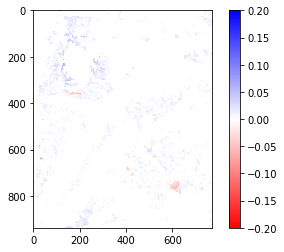

In [44]:
plt.imshow(w_ / (w_ + d_) - w0 / (w0 + d0), vmax=0.2, vmin=-0.2, cmap='bwr_r'); plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


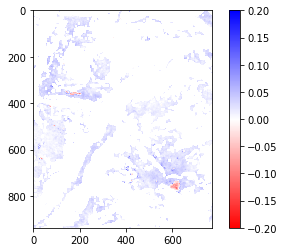

In [45]:
plt.imshow(w1 / (w1 + d1) - w_ / (w_ + d_), vmax=0.2, vmin=-0.2, cmap='bwr_r'); plt.colorbar(); None

## Change attributable to new cloud *shadow* mask

/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


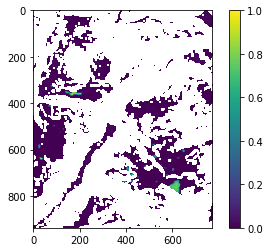

In [46]:
w_ = (((z0 & ~np.uint8(32)) | (z1 & np.uint8(32))) == 128).sum(axis=0)
d_ = (((z0 & ~np.uint8(32)) | (z1 & np.uint8(32))) == 0).sum(axis=0)
plt.imshow(w_ / (w_ + d_)); plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


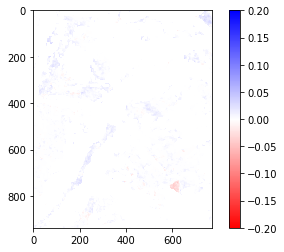

In [47]:
plt.imshow(w_ / (w_ + d_) - w0 / (w0 + d0), vmax=0.2, vmin=-0.2, cmap='bwr_r'); plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


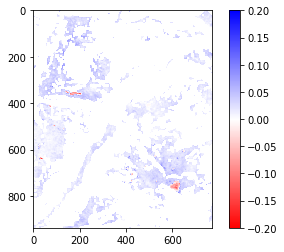

In [48]:
plt.imshow(w1 / (w1 + d1) - w_ / (w_ + d_), vmax=0.2, vmin=-0.2, cmap='bwr_r'); plt.colorbar(); None

## Quantifying the change

/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


0 1 -1.869% 7.887% nodata 29.411%
1 2 -4.889% 36.390% noncontig 29.632%
2 4 0.000% 0.000% sea 0.000%
3 8 32.185% 43.335% terrain 76.004%
4 16 -0.013% 0.139% slope 0.148%
5 32 12.485% 27.691% cloud shadow 51.061%
6 64 26.663% 36.993% cloud 61.901%
7 128 0.846% 17.949% water 15.547%


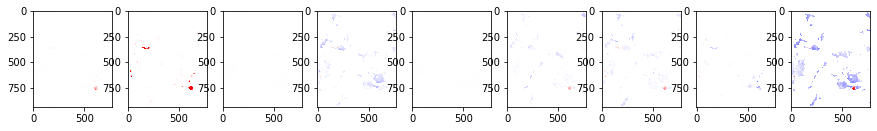

In [129]:
def summary(x):
    wet = (x == 128).sum(axis=0)
    dry = (x == 0).sum(axis=0)
    return wet / (wet + dry)

original = summary(z0)
final = summary(z1)
delta0 = final - original

def extent(x):
    return np.isfinite(x) & (x != 0)
#change = extent(original) ^ extent(final)
change = extent(final - original)
def extentmeasure(x):
    return '%0.3f%%' % (100 * extent(x - original)[change].mean())

def measure(x):
    delta = x - original
    delta[~np.isfinite(delta)] = 0
    normalised = delta / delta0
    m = normalised[np.isfinite(normalised)].mean()
    m2 = np.abs(normalised)[np.isfinite(normalised)].mean()
    return ' '.join(['%0.3f%%' % (100 * i) for i in [m, m2]])

def hybrid(bitmask):
    bitmask = np.uint8(bitmask)
    return summary((z0 & ~bitmask) | (z1 & bitmask))


plt.figure(figsize=(15,5))

for i, desc in enumerate(['nodata', 'noncontig', 'sea', 'terrain', 'slope', 'cloud shadow', 'cloud', 'water']):

    bit = 2**i
    candidate = hybrid(bit)
    explains = measure(candidate)
    print(i, bit, explains, desc, extentmeasure(candidate))
    plt.subplot(1,9,i+1).imshow(candidate - original, vmax=0.1, vmin=-0.1, cmap='bwr_r')
    
plt.subplot(1,9,9).imshow(delta0, vmax=0.1, vmin=-0.1, cmap='bwr_r'); None

In [119]:
extentmeasure(final)

0.9449182155841912

In order of contribution:

- The **terrain/insolation** explains perhaps a third of the change.

- **Cloud** explains more than a quarter of the change.

- **Cloud shadow** explains more than 10% of the change. (Both cloud effects combined are barely as substantial as terrain insolation.)

- The **nodata** and especially **noncontiguous** data extents are different, particularly over waterbody-like features. (This has tended to reduce the flood frequency of potential water bodies, although it is counter-acted by other changes.)

- The **water classifier** itself explains perhaps 1% of the change. This particularly concerns water bodies.

- The high **slope** mask has only negligible differences, and the **sea** mask has no effect.


/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


('27.746% 44.023%', '67.046%')

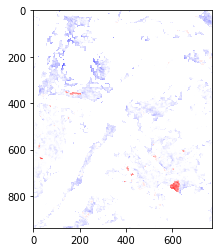

In [132]:
x = hybrid(64 + 32) # cloud and cloud shadow
plt.imshow(x - original, vmax=0.1, vmin=-0.1, cmap='bwr_r')
measure(x), extentmeasure(x)

/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


('97.583% 115.088%', '97.057%')

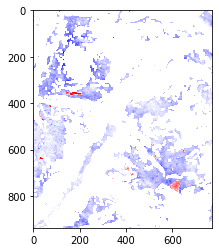

In [284]:
x = hybrid(64 + 8) # cloud and terrain
plt.imshow(x - original, vmax=0.1, vmin=-0.1, cmap='bwr_r')
measure(x), extentmeasure(x)

/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


('-0.197% 41.064%', '44.832%')

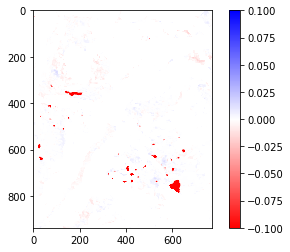

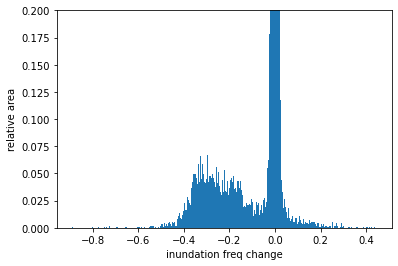

In [229]:
x = hybrid(2 + 1 + 128) # noncontig, nodata, water
plt.imshow(x - original, vmax=0.1, vmin=-0.1, cmap='bwr_r')
plt.colorbar()

plt.figure()
plt.hist((x-original).ravel(), bins=500, density=True)
plt.ylim(0, 0.2)
plt.xlabel('inundation freq change')
plt.ylabel('relative area')

measure(x), extentmeasure(x)

/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


('0.846% 17.949%', '15.547%')

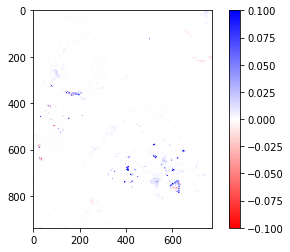

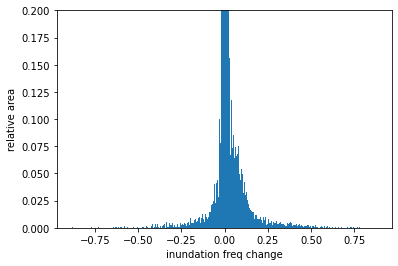

In [230]:
x = hybrid(128) # only the water classifier
plt.imshow(x - original, vmax=0.1, vmin=-0.1, cmap='bwr_r')
plt.colorbar()

plt.figure()
plt.hist((x-original).ravel(), bins=500, density=True)
plt.ylim(0, 0.2)
plt.xlabel('inundation freq change')
plt.ylabel('relative area')

measure(x), extentmeasure(x)

The water classifier changes usually only act to slightly modify (more often enhance) the WOfS summary frequency. However, the nodata/noncontig changes are very focussed, often subtracting an absolute 30%-40% from the feature inundation summary. 

## Loss of sensitivity

Why is that lake exhibiting a local reduction in frequency?

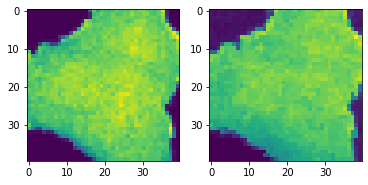

In [49]:
s0 = z0[:, 740:780, 590:630]
s1 = z1[:, 740:780, 590:630]
plt.subplot(1,2,1).imshow((s0==128).sum(axis=0))
plt.subplot(1,2,2).imshow((s1==128).sum(axis=0)) # Not using same colour ramp (shape spatial comparison of wet counts)

In [243]:
(s0 == 128).mean(), (s0 == 0).mean(), (s1 == 128).mean(), (s1 == 0).mean() # wet and dry "counts"  (old wet & dry, new wet & dry)

(0.11918968023255815,
 0.06440406976744185,
 0.18166061046511628,
 0.13216206395348837)

In [244]:
((s0 == 128) | (s0 == 0)).mean(), ((s1 == 128) | (s1 == 0)).mean() # clear "counts" (old and new)

(0.18359375, 0.3138226744186047)

In [52]:
(s0 == 128).mean() / ((s0 == 128) | (s0 == 0)).mean(), (s1 == 128).mean() / ((s1 == 128) | (s1 == 0)).mean() # wet fraction among clear observations

(0.649203364670955, 0.5788638784678801)

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


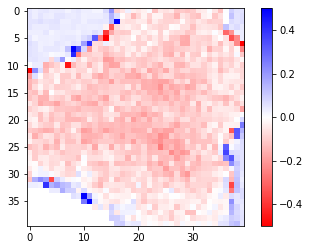

In [245]:
plt.imshow((s1 == 128).sum(axis=0) / ((s1 == 128) | (s1 == 0)).sum(axis=0) - (s0 == 128).sum(axis=0) / ((s0 == 128) | (s0 == 0)).sum(axis=0), cmap='bwr_r', vmin=-0.5, vmax=0.5)
plt.colorbar(); None

In [246]:
ss0 = s0[:, 15:-15, 15:-15]
ss1 = s1[:, 15:-15, 15:-15]

-0.12267976272714046 -0.12840005889324152


(0.7832167832167832, 0.6603394372487718)

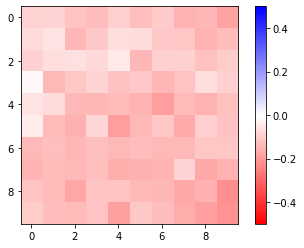

In [250]:
ss_delta = (ss1 == 128).sum(axis=0) / ((ss1 == 128) | (ss1 == 0)).sum(axis=0) - (ss0 == 128).sum(axis=0) / ((ss0 == 128) | (ss0 == 0)).sum(axis=0)
plt.imshow(ss_delta, cmap='bwr_r', vmin=-0.5, vmax=0.5)
plt.colorbar()
print(np.mean(ss_delta), np.median(ss_delta))
(ss0 == 128).mean() / ((ss0 == 128) | (ss0 == 0)).mean(), (ss1 == 128).mean() / ((ss1 == 128) | (ss1 == 0)).mean() # wet fraction among clear observations

There are certainly edge effects at the periphery of the water body, which may be attributable to projection effects.

There are almost twice as many "clear" observations of the lake now. More wet observations *and* more dry observations. However, the central area inundation frequency has only marginally decreased (78% -> 66%). Perhaps this 12% absolute change, in the context of a doubling of "clear" observations, isn't enough to demand any explanation?

Nonetheless, the differences here remain mostly attributable to the terrain mask, although the cloud shadow mask is also significant (and cloud to a much lesser extent). The classifier and nodata/noncontig appear unimportant at this stage.

In [266]:
mismatch = (s0 & ~np.uint8(128)).astype(np.bool) ^ (s1 & ~np.uint8(128)).astype(np.bool) # differences in whether a pixel is masked (regardless of reason)

for i, desc in enumerate(['nodata  ', 'noncontig', 'sea    ', 'terrain', 'slope  ', 'cloud shadow', 'cloud  ']):
    m = (s0[mismatch] & 2**i).astype(np.bool).mean()
    m2 = (s1[mismatch] & 2**i).astype(np.bool).mean()
    print('%i \t %.1f%% \t %.1f%% \t %+05.1f%% \t %i \t'  % (i, m * 100, m2 * 100, (m2 - m) * 100, 2**i) + desc)

0 	 1.5% 	 0.6% 	 -00.9% 	 1 	nodata  
1 	 1.4% 	 0.3% 	 -01.2% 	 2 	noncontig
2 	 0.0% 	 0.0% 	 +00.0% 	 4 	sea    
3 	 64.2% 	 0.0% 	 -64.2% 	 8 	terrain
4 	 0.5% 	 0.1% 	 -00.4% 	 16 	slope  
5 	 42.2% 	 7.6% 	 -34.6% 	 32 	cloud shadow
6 	 19.9% 	 0.4% 	 -19.4% 	 64 	cloud  


For example, among the pixels (in the lake neighbourhood) that were clear in only one of the collections (and so can contribute to a tangible change in WOfS), >40% used to be masked "cloud shadow" (now interpreted clear) and 8% used to be clear/unmasked (now interpreted "cloud shadow"), giving a large *net reduction* in the amount interpreted as "cloud shadow". (The effect is more drastic for terrain insolation, and less extreme for cloud. No other masks are comparable.)

Now, focusing on the lake interior, to investigate whether particular mask updates are responsible for changes in wet/dry bias:

- Recall that overall, the area reads as 70% wet (+/- depending on collection).
- Less than 20% of pixels have a consensus clear wet or clear dry status between collections. These are 80% wet.
- The terrain/insolation makes by far the largest increase to the clear count. Cloud shadow is half as large. Cloud is half that again.
- Each of the individual mask updates biases the inundation frequency toward drier proportions. (This is weaker for terrain, stronger for nodata/noncontig and cloud shadow.) 



In [287]:
missmatch = (ss0 & ~np.uint8(128)).astype(np.bool) ^ (ss1 & ~np.uint8(128)).astype(np.bool) # differences in whether a pixel is masked (regardless of reason)

for i, desc in enumerate(['nodata  ', 'noncontig', 'sea    ', 'terrain', 'slope  ', 'cloud shadow', 'cloud  ']):
    m = (ss0[missmatch] & 2**i).astype(np.bool).mean() # prev mask portion
    m2 = (ss1[missmatch] & 2**i).astype(np.bool).mean() # future mask portion
    plus_dry = (missmatch & (ss1 == 0) & (ss0 & 2**i).astype(np.bool)).mean() - (missmatch & (ss0 == 0) & (ss1 & 2**i).astype(np.bool)).mean()
    plus_wet = (missmatch & (ss1 == 128) & (ss0 & 2**i).astype(np.bool)).mean() - (missmatch & (ss0 == 128) & (ss1 & 2**i).astype(np.bool)).mean()
    print('%i \t %.1f%% \t %.1f%% \t %+05.1f%% \t %i \t'  % (i, m * 100, m2 * 100, (m2 - m) * 100, 2**i) + desc, 
          '\t %+05.2f %+05.2f %.2f \t %.2f' % (100*plus_wet, 100*plus_dry, 100*(plus_wet+plus_dry), 100*(plus_wet)/(plus_wet+plus_dry)))
    
(((ss0 == 128) & (ss1 == 128)) | ((ss0 == 0) & (ss1 == 0))).mean(), (
    ((ss0 == 128) & (ss1 == 128)).sum(axis=0) / (((ss0 == 128) & (ss1 == 128)) | ((ss0 == 0) & (ss1 == 0))).sum(axis=0) 
    ).mean() # consensus portion, and inundation freq according to consensus

0 	 1.7% 	 0.6% 	 -01.1% 	 1 	nodata   	 +0.02 +0.19 0.21 	 9.35
1 	 1.2% 	 0.2% 	 -01.0% 	 2 	noncontig 	 +0.06 +0.13 0.19 	 30.61
2 	 0.0% 	 0.0% 	 +00.0% 	 4 	sea     	 +0.00 +0.00 0.00 	 nan
3 	 66.6% 	 0.0% 	 -66.6% 	 8 	terrain 	 +6.70 +5.57 12.27 	 54.57
4 	 0.0% 	 0.0% 	 +00.0% 	 16 	slope   	 +0.00 +0.00 0.00 	 nan
5 	 42.4% 	 9.5% 	 -33.0% 	 32 	cloud shadow 	 +2.10 +3.98 6.08 	 34.55
6 	 18.5% 	 0.4% 	 -18.1% 	 64 	cloud   	 +1.35 +1.98 3.33 	 40.43


/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


(0.15585271317829458, 0.8178178029985983)

0.005518631232737058

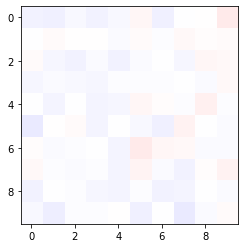

In [298]:
updated = (ss0 & ~np.uint8(8)) | (ss1 & 8)
delta = summary(updated) - summary(ss0)
plt.imshow(delta, cmap='bwr_r', vmin=-0.5, vmax=0.5)
delta.mean()

In [306]:
((updated != ss0) & (ss0 == 0)).mean()

0.0

In [308]:
15.8/(15.8+4.4), (15.8+4.7)/(15.8+4.7+4.4+1.1), 

(0.7821782178217821, 0.7884615384615384)

In [56]:
(s0 & 32).astype(np.bool).mean(), (s1 & 32).astype(np.bool).mean(), ((s0 & 32).astype(np.bool) & (s1 & 32).astype(np.bool)).mean(), (~(s0 & 32).astype(np.bool) ^ ~(s1 & 32).astype(np.bool)).mean(), 

(0.08825218023255814,
 0.04496608527131783,
 0.013596172480620155,
 0.8803779069767442)

5% of the time, this lake is now classified as cloud shadow. A quarter of these observations used to be deemed clear, and specifically, wet.

It was previously classified as cloud shadow 9% of the time, but those observations are now interpreted as mostly clear, and specifically, dry just as often as wet.

Overall, this increases the dry fraction of clear observations.

The cloud shadow for this lake has reduced from 9% to 4%, with minimal overlap or little consistently between what was and now is deemed cloud affected.

## Noncontiguous/nodata over waterbodies?

Even if the contribution is minor, it is surprising that some detailed landscape features should be selectively depressed (in the WOfS summary) by the flags that have the most landscape-independant targets.

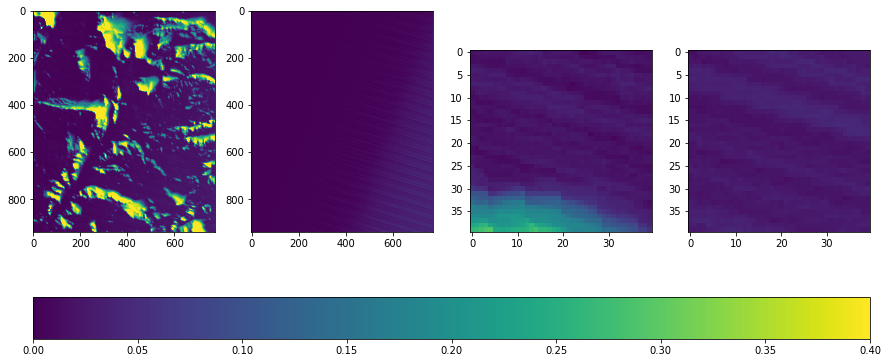

In [151]:
fig, axes = plt.subplots(1, 4, figsize=(15, 8))
axes[0].imshow((z0 & 1).astype(np.bool).mean(axis=0), vmin=0, vmax=0.4) # The NODATA mask
axes[1].imshow((z1 & 1).astype(np.bool).mean(axis=0), vmin=0, vmax=0.4)
axes[2].imshow((s0 & 1).astype(np.bool).mean(axis=0), vmin=0, vmax=0.4)
p = axes[3].imshow((s1 & 1).astype(np.bool).mean(axis=0), vmin=0, vmax=0.4)
plt.colorbar(p, ax=axes, location='bottom'); None

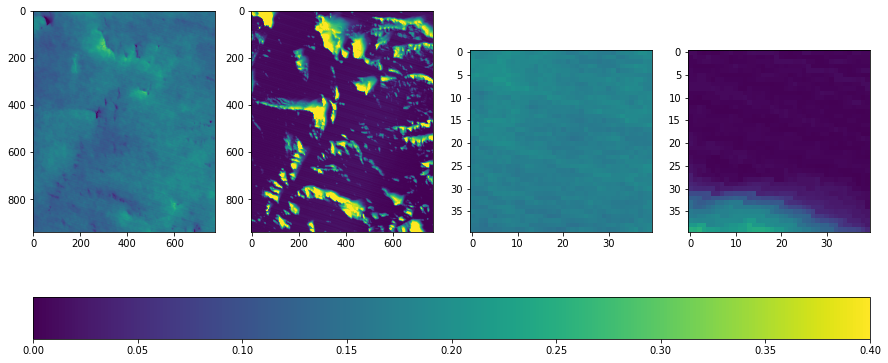

In [152]:
fig, axes = plt.subplots(1, 4, figsize=(15, 8))
axes[0].imshow((z0 & 2).astype(np.bool).mean(axis=0), vmin=0, vmax=0.4) # The NONCONTIG mask
axes[1].imshow((z1 & 2).astype(np.bool).mean(axis=0), vmin=0, vmax=0.4)
axes[2].imshow((s0 & 2).astype(np.bool).mean(axis=0), vmin=0, vmax=0.4)
p = axes[3].imshow((s1 & 2).astype(np.bool).mean(axis=0), vmin=0, vmax=0.4)
plt.colorbar(p, ax=axes, location='bottom'); None

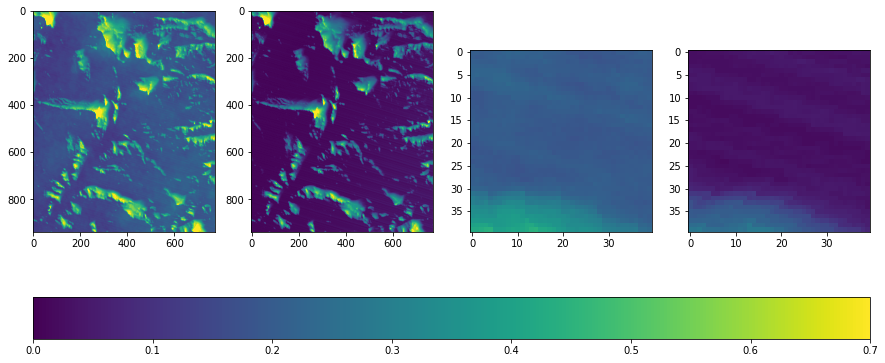

In [154]:
fig, axes = plt.subplots(1, 4, figsize=(15, 8))
axes[0].imshow((z0 & 3).astype(np.bool).mean(axis=0), vmin=0, vmax=0.7) # This is EITHER of the two mask
axes[1].imshow((z1 & 3).astype(np.bool).mean(axis=0), vmin=0, vmax=0.7)
axes[2].imshow((s0 & 3).astype(np.bool).mean(axis=0), vmin=0, vmax=0.7)
p = axes[3].imshow((s1 & 3).astype(np.bool).mean(axis=0), vmin=0, vmax=0.7)
plt.colorbar(p, ax=axes, location='bottom'); None

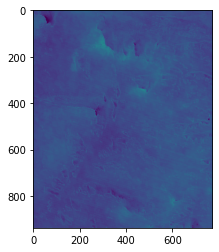

In [158]:
plt.imshow(((z0 & 3).astype(np.bool) ^ (z1 & 3).astype(np.bool)).sum(axis=0)) # difference (between collections) for these masks

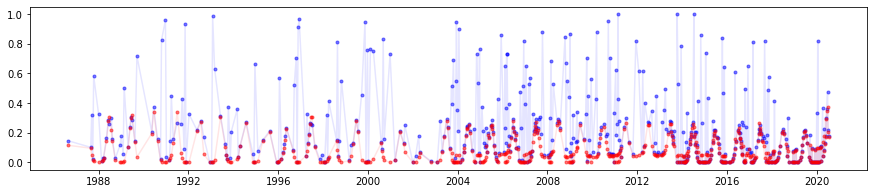

In [310]:
t = x0.time.values
ty = x0.time.to_pandas().dt.dayofyear.values
plt.figure(figsize=(15,3))
plt.plot(t, (z0 & 3).astype(np.bool).mean(axis=(1,2)), 'b', alpha=0.1)
plt.plot(t, (z0 & 3).astype(np.bool).mean(axis=(1,2)), '.b', alpha=0.5)
plt.plot(t, (z1 & 3).astype(np.bool).mean(axis=(1,2)), 'r', alpha=0.1)
plt.plot(t, (z1 & 3).astype(np.bool).mean(axis=(1,2)), '.r', alpha=0.5)

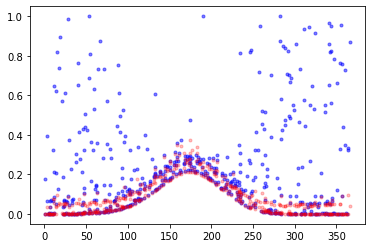

In [182]:
plt.plot(ty, (z0 & 3).astype(np.bool).mean(axis=(1,2)), '.b', alpha=0.5)
plt.plot(ty, (z1 & 3).astype(np.bool).mean(axis=(1,2)), '.r', alpha=0.25)

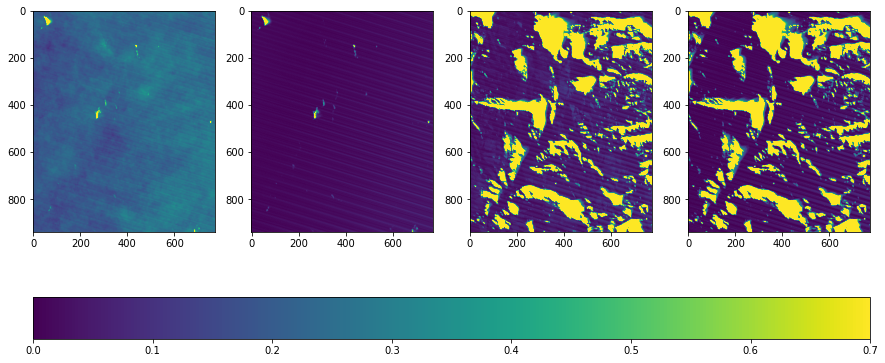

In [184]:
winter = (ty > 150) & (ty < 200)
summer = (ty < 50) | (ty > 300)

fig, axes = plt.subplots(1, 4, figsize=(15, 8))
axes[0].imshow((z0[summer] & 3).astype(np.bool).mean(axis=0), vmin=0, vmax=0.7) # This is the SEASONALITY of the masks
axes[1].imshow((z1[summer] & 3).astype(np.bool).mean(axis=0), vmin=0, vmax=0.7)
axes[2].imshow((z0[winter] & 3).astype(np.bool).mean(axis=0), vmin=0, vmax=0.7)
p = axes[3].imshow((z1[winter] & 3).astype(np.bool).mean(axis=0), vmin=0, vmax=0.7)
plt.colorbar(p, ax=axes, location='bottom'); None

This is strange: it seems some kind of seasonal effect (perhaps oversaturation due to snow?) has been reclassified from "nodata" to "noncontiguous", and the overall background level of masking (perhaps oversaturation due to cloud?) has reduced; these might represent fixes and claimed-improvements of the upstream ARD processing.

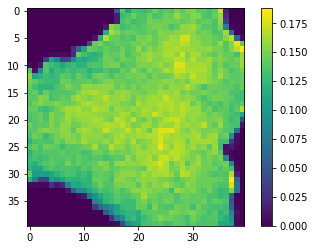

In [232]:
plt.imshow((s0 == 128).mean(axis=0)); plt.colorbar(); None

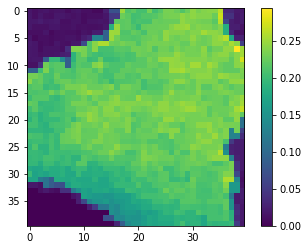

In [234]:
plt.imshow((s1 == 128).mean(axis=0)); plt.colorbar(); None